# **Predicting fake news using word embeddings and comparing their performance**

In [180]:
#We have fake and real news dataset. Link to the dataset: "https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv".
#The dataset contains the following columns: "title","text","subject","date". There are two seperate dataset for fake and real news.
#We take 500 rows from both dataset and then combine them to form a single dataset with additional column conveying whether news is real or fake.
#Then we use word embedding models to create vector from the available news text column.
#The word embeddings used are: word2vec, BERT-base, BERT-Large and AlBERT.
#After creating the vectors from these word embedding models, we train a binary classification model to predict whether news is real or fake.
#Our novel application with this programming assignment is that we are comparing various word embedding models on this specific task of fake news prediction.
#Word embeddings play a huge role in predicting the label. The vector produced includes various features in numerical form which differs from model to model.
#We try to figure out which word embedding model creates the best vectors assisting in predicting fake news.
#The explanation is given at each step in respective code chunks.
#The results are summarised at the end.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

# **Connecting to google drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading the datasets**

In [83]:
fakepath = '/content/drive/MyDrive/NLP/Fake.csv'

In [84]:
truepath = '/content/drive/MyDrive/NLP/True.csv'

In [85]:
fakenews = spark.read.csv(fakepath, header = True)

In [86]:
fakenews.show(20)

+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|
| WATCH: Brand-New...|Just when you mig...|   News|December 21, 2017|
| Papa John’s Foun...|A centerpiece of ...|   News|December 21, 2017|
| WATCH: Paul Ryan..

In [87]:
truenews = spark.read.csv(truepath, header = True)

In [88]:
truenews.show(20)

+--------------------+--------------------+--------------------+------------------+
|               title|                text|             subject|              date|
+--------------------+--------------------+--------------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|December 29, 2017 |
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |
|Factbox: Trump on...|The following sta...|        politicsNews|December 29, 2017 |
|Trump on Twitter ...|The following sta...|        politicsNews|December 29,

In [89]:
#Converting both dataframes to pandas dataframe and sampling random 500 rows from both the dataframes
import pandas as pd
fakenewspd = fakenews.toPandas()
fakenewspd = fakenewspd.sample(n=500, random_state=2)
fakenewspd.head()

,title,text,subject,date
15154,CASTRO IGNORES DISASTROUS COMMUNIST POLICIES T...,If Obama had a communist friend he d be this p...,politics,"Sep 29, 2015"
7624,Gun Industry Has NO SHAME In Their PATHETIC S...,While one could argue that the Second Amendmen...,News,"March 8, 2016"
12996,STUNNING DEVELOPMENT: OBAMA GIVES $75 MILLION ...,You have got to be kidding me! After all the t...,politics,"Sep 17, 2016"
14424,STUNNING! FORMER DISNEY TECH WORKER’S Emotiona...,,politics,"Feb 25, 2016"
20655,"LONG TIME DEMOCRATS, UNION WORKERS Explain Why...",As millions of dollars of union dues flow into...,left-news,"May 1, 2016"


In [90]:
truenewspd = truenews.toPandas()
truenewspd = truenewspd.sample(n=500,random_state=2)
truenewspd.head()

,title,text,subject,date
6176,'Numerous' arrests made during Trump inaugurat...,WASHINGTON (Reuters) - Washington police made ...,politicsNews,"January 20, 2017"
8278,Trump calls for new civil rights agenda in vis...,DETROIT (Reuters) - Republican presidential ca...,politicsNews,"September 3, 2016"
14529,U.S. urges African nations to press North Kore...,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,"November 17, 2017"
10614,Congresswoman quits Democratic National Commit...,WASHINGTON (Reuters) - Democratic National Com...,politicsNews,"February 28, 2016"
2705,"Trump, after Senate bill collapses, vows 'grea...",WASHINGTON (Reuters) - After Republicans’ effo...,politicsNews,"July 18, 2017"


In [91]:
#Adding newstype column to both the dataframes
fakenewspd["newstype"] = ["fake"]*len(fakenewspd)

In [92]:
fakenewspd.head()

,title,text,subject,date,newstype
15154,CASTRO IGNORES DISASTROUS COMMUNIST POLICIES T...,If Obama had a communist friend he d be this p...,politics,"Sep 29, 2015",fake
7624,Gun Industry Has NO SHAME In Their PATHETIC S...,While one could argue that the Second Amendmen...,News,"March 8, 2016",fake
12996,STUNNING DEVELOPMENT: OBAMA GIVES $75 MILLION ...,You have got to be kidding me! After all the t...,politics,"Sep 17, 2016",fake
14424,STUNNING! FORMER DISNEY TECH WORKER’S Emotiona...,,politics,"Feb 25, 2016",fake
20655,"LONG TIME DEMOCRATS, UNION WORKERS Explain Why...",As millions of dollars of union dues flow into...,left-news,"May 1, 2016",fake


In [93]:
truenewspd["newstype"] = ["true"]*len(truenewspd)

In [94]:
truenewspd.head()

,title,text,subject,date,newstype
6176,'Numerous' arrests made during Trump inaugurat...,WASHINGTON (Reuters) - Washington police made ...,politicsNews,"January 20, 2017",true
8278,Trump calls for new civil rights agenda in vis...,DETROIT (Reuters) - Republican presidential ca...,politicsNews,"September 3, 2016",true
14529,U.S. urges African nations to press North Kore...,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,"November 17, 2017",true
10614,Congresswoman quits Democratic National Commit...,WASHINGTON (Reuters) - Democratic National Com...,politicsNews,"February 28, 2016",true
2705,"Trump, after Senate bill collapses, vows 'grea...",WASHINGTON (Reuters) - After Republicans’ effo...,politicsNews,"July 18, 2017",true


In [95]:
#Joining both the dataframes as a single dataframe
news = pd.concat([fakenewspd,truenewspd])

In [96]:
news.head()

,title,text,subject,date,newstype
15154,CASTRO IGNORES DISASTROUS COMMUNIST POLICIES T...,If Obama had a communist friend he d be this p...,politics,"Sep 29, 2015",fake
7624,Gun Industry Has NO SHAME In Their PATHETIC S...,While one could argue that the Second Amendmen...,News,"March 8, 2016",fake
12996,STUNNING DEVELOPMENT: OBAMA GIVES $75 MILLION ...,You have got to be kidding me! After all the t...,politics,"Sep 17, 2016",fake
14424,STUNNING! FORMER DISNEY TECH WORKER’S Emotiona...,,politics,"Feb 25, 2016",fake
20655,"LONG TIME DEMOCRATS, UNION WORKERS Explain Why...",As millions of dollars of union dues flow into...,left-news,"May 1, 2016",fake


In [97]:
news['newstype'].value_counts()

fake    500
true    500
Name: newstype, dtype: int64

In [98]:
#Adding a column - "Fake", which has boolean values. 1 if news is fake and 0 if news is true
news['fake'] = news['newstype'].apply(lambda x : 1 if x == "fake" else 0)

In [99]:
news.head()

,title,text,subject,date,newstype,fake
15154,CASTRO IGNORES DISASTROUS COMMUNIST POLICIES T...,If Obama had a communist friend he d be this p...,politics,"Sep 29, 2015",fake,1
7624,Gun Industry Has NO SHAME In Their PATHETIC S...,While one could argue that the Second Amendmen...,News,"March 8, 2016",fake,1
12996,STUNNING DEVELOPMENT: OBAMA GIVES $75 MILLION ...,You have got to be kidding me! After all the t...,politics,"Sep 17, 2016",fake,1
14424,STUNNING! FORMER DISNEY TECH WORKER’S Emotiona...,,politics,"Feb 25, 2016",fake,1
20655,"LONG TIME DEMOCRATS, UNION WORKERS Explain Why...",As millions of dollars of union dues flow into...,left-news,"May 1, 2016",fake,1


In [100]:
news['fake'].value_counts()

1    500
0    500
Name: fake, dtype: int64

In [101]:
#Removing all rows with null values
news1 = news.dropna()

In [102]:
news1['fake'].value_counts()

1    500
0    500
Name: fake, dtype: int64

# **Word2Vec text embedding**

In [103]:
#Word2vec text embedding will generate vectors for each word in the sentence
#It will not generate a single vector for a sentence
#Here we clean the text part and generate vectors for each word in the text
#After this step, we split our dataset into test and train
#Then we combine the vectors of all words in a sentence in an array
#Next, we take average of all elements of vectors in a sentence to form a single vector for each sentence
#After getting the vectors, we train the random forest classification model and use these vectors as input
#Then at last, we evaluate our model by making predictions on test set and measuring accuracy, recall and precision

In [104]:
import gensim
from sklearn.model_selection import train_test_split

In [105]:
#Clean data using the built in cleaner in gensim
news1['text_clean'] = news1['text'].apply(lambda x: gensim.utils.simple_preprocess(x))
news1.head()

,title,text,subject,date,newstype,fake,text_clean
15154,CASTRO IGNORES DISASTROUS COMMUNIST POLICIES T...,If Obama had a communist friend he d be this p...,politics,"Sep 29, 2015",fake,1,"[if, obama, had, communist, friend, he, be, th..."
7624,Gun Industry Has NO SHAME In Their PATHETIC S...,While one could argue that the Second Amendmen...,News,"March 8, 2016",fake,1,"[while, one, could, argue, that, the, second, ..."
12996,STUNNING DEVELOPMENT: OBAMA GIVES $75 MILLION ...,You have got to be kidding me! After all the t...,politics,"Sep 17, 2016",fake,1,"[you, have, got, to, be, kidding, me, after, a..."
14424,STUNNING! FORMER DISNEY TECH WORKER’S Emotiona...,,politics,"Feb 25, 2016",fake,1,[]
20655,"LONG TIME DEMOCRATS, UNION WORKERS Explain Why...",As millions of dollars of union dues flow into...,left-news,"May 1, 2016",fake,1,"[as, millions, of, dollars, of, union, dues, f..."


In [161]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split (news1['text_clean'], news1['fake'],random_state = 3)

In [162]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train,
                                   size=100,
                                   window=5,
                                   min_count=2)

In [163]:
#Generate aggregated sentence vectors based on the word vectors for each word in the sentence
#This code makes an array of all the sentences in which each sentence is an array of words in that sentence
import numpy as np
words = set(w2v_model.wv.index2word )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [164]:
# Why is the length of the sentence different than the length of the sentence vector?
#Here as seen, we see that each sentence has different no. of vectors.
# This is going to be difficult to train the model
for i, v in enumerate(X_train_vect):
    print(len(X_train.iloc[i]), len(v))

93 92
198 195
679 669
412 398
1224 1196
72 69
117 117
185 182
260 249
309 303
509 503
63 60
471 460
67 65
198 195
708 692
745 723
122 120
270 268
347 343
306 292
379 366
325 311
347 333
138 137
2 2
219 217
328 326
583 548
714 687
873 867
702 683
70 70
115 114
378 374
51 49
329 329
506 492
283 277
114 114
0 0
185 183
389 370
175 174
463 455
475 469
194 191
199 198
261 261
75 72
193 190
294 288
270 259
437 412
278 261
825 801
479 467
328 313
524 513
176 174
227 219
95 89
267 252
59 58
280 265
386 365
258 255
332 323
235 228
196 189
588 571
294 280
303 297
801 783
274 272
337 316
98 89
716 706
495 485
472 467
613 608
73 73
204 201
633 619
551 516
24 19
162 156
60 60
478 470
365 360
601 596
178 174
338 333
803 772
469 462
613 604
1370 1346
402 393
359 347
486 475
137 134
63 63
56 56
307 298
492 476
493 477
215 204
78 77
338 334
632 619
1166 1123
268 261
139 137
219 216
288 288
498 489
171 171
262 256
133 130
768 737
358 347
311 304
508 497
315 313
610 593
490 480
675 666
274 263
205 193
35

In [165]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
#Here, we are averaging all features of vectors in a sentence to get a single vector for each sentence having 100 dimensions
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

In [166]:
# Are our sentence vector lengths consistent?
for i, v in enumerate(X_train_vect_avg):
    print(len(X_train.iloc[i]), len(v))

93 100
198 100
679 100
412 100
1224 100
72 100
117 100
185 100
260 100
309 100
509 100
63 100
471 100
67 100
198 100
708 100
745 100
122 100
270 100
347 100
306 100
379 100
325 100
347 100
138 100
2 100
219 100
328 100
583 100
714 100
873 100
702 100
70 100
115 100
378 100
51 100
329 100
506 100
283 100
114 100
0 100
185 100
389 100
175 100
463 100
475 100
194 100
199 100
261 100
75 100
193 100
294 100
270 100
437 100
278 100
825 100
479 100
328 100
524 100
176 100
227 100
95 100
267 100
59 100
280 100
386 100
258 100
332 100
235 100
196 100
588 100
294 100
303 100
801 100
274 100
337 100
98 100
716 100
495 100
472 100
613 100
73 100
204 100
633 100
551 100
24 100
162 100
60 100
478 100
365 100
601 100
178 100
338 100
803 100
469 100
613 100
1370 100
402 100
359 100
486 100
137 100
63 100
56 100
307 100
492 100
493 100
215 100
78 100
338 100
632 100
1166 100
268 100
139 100
219 100
288 100
498 100
171 100
262 100
133 100
768 100
358 100
311 100
508 100
315 100
610 100
490 100
675 100
2

In [167]:
#Fitting a basic Random Forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train.values.ravel())

In [168]:
#Making predictions on the test data 
y_pred = rf_model.predict(X_test_vect_avg)

In [169]:
#Calculating precision, recall and accuracy
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))


Precision: 0.912 / Recall: 0.798 / Accuracy: 0.856


In [170]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
cm 

array([[111,  10],
       [ 26, 103]])

Text(33.0, 0.5, 'Truth')

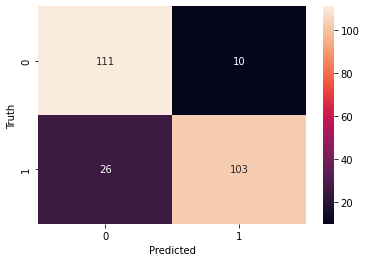

In [171]:
#Heatmap
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [172]:
#Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       121
           1       0.91      0.80      0.85       129

    accuracy                           0.86       250
   macro avg       0.86      0.86      0.86       250
weighted avg       0.86      0.86      0.86       250



# **Contextual embeddings using BERT-base model**

In [118]:
#Here, we are using the BERT-base model to obtain vectors from each news text
#BERT-base model is used which contains 12 hidden layers, hidden size of 768 and 12 attention heads
#We split our dataset into test and train
#We define the bert model consisting of input, preprocessing, encoding, neural network layers and finally producing output
#These outputs are the probability values of the news text being fake or not. If these values are greater than 0.5, we assign fake label or 1 in our case. Otherwise, we provide label as 0.
#Then we fit these models in 5 epochs


In [119]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [120]:
!pip install -q tf-models-official==2.7.0

In [121]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [122]:
#Splitting into test and train
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(news1['text'],news1["fake"], stratify = news1['fake'],random_state = 2)

In [123]:
X_train1.head(4)

18871    ALMATY (Reuters) - The first prominent disside...
7128     To say that David Brooks is not impressed with...
10175    Katie Couric took to Twitter to call out Charl...
17264    And they re heading to Cape Cod next! Where do...
Name: text, dtype: object

In [128]:
#BERT preprocessor and BERT encoder
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


In [129]:
#Defining the bert model consisting of input, preprocessing, encoding, neural network layers and finally producing output
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [130]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [131]:
#Defining metrics for model evaluation
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)


In [132]:
#Fitting the model
model.fit(X_train1, y_train1, epochs=5)

Epoch 1/5
24/24 [==============================] - 370s 15s/step - loss: 0.6927 - accuracy: 0.5680 - precision: 0.5739 - recall: 0.5280
Epoch 2/5
24/24 [==============================] - 355s 15s/step - loss: 0.6027 - accuracy: 0.7493 - precision: 0.7726 - recall: 0.7067
Epoch 3/5
24/24 [==============================] - 355s 15s/step - loss: 0.5516 - accuracy: 0.7747 - precision: 0.7754 - recall: 0.7733
Epoch 4/5
24/24 [==============================] - 354s 15s/step - loss: 0.4982 - accuracy: 0.8333 - precision: 0.8788 - recall: 0.7733
Epoch 5/5
24/24 [==============================] - 354s 15s/step - loss: 0.4630 - accuracy: 0.8453 - precision: 0.8472 - recall: 0.8427


In [133]:
model.evaluate(X_test1, y_test1)

8/8 [==============================] - 121s 15s/step - loss: 0.4750 - accuracy: 0.8560 - precision: 0.8739 - recall: 0.8320


[0.4749678671360016,
 0.8560000061988831,
 0.8739495873451233,
 0.8320000171661377]

In [134]:
#Making predictions
y_predicted1 = model.predict(X_test1)
y_predicted1 = y_predicted1.flatten()

In [135]:
#Changing probability values to 0 and 1 based on whether the value is greater than 0.5 or not
import numpy as np
y_predicted1 = np.where(y_predicted1 > 0.5, 1, 0)
y_predicted1

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1])

In [136]:
#confusion metrics
from sklearn.metrics import confusion_matrix, classification_report
cm1 = confusion_matrix(y_test1, y_predicted1)
cm1

array([[110,  15],
       [ 21, 104]])

Text(33.0, 0.5, 'Truth')

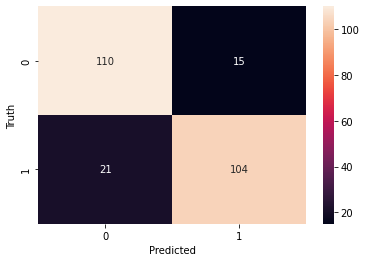

In [137]:
#heat map
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm1, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [138]:
print(classification_report(y_test1, y_predicted1))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       125
           1       0.87      0.83      0.85       125

    accuracy                           0.86       250
   macro avg       0.86      0.86      0.86       250
weighted avg       0.86      0.86      0.86       250



# **Contextual embeddings using BERT-Large model**

In [139]:
#This model contains 24 layers, 16 Attention layers and 1024 hidden dimensions
#We split our dataset into test and train
#We define the bert model consisting of input, preprocessing, encoding, neural network layers and finally producing output
#These outputs are the probability values of the news text being fake or not. If these values are greater than 0.5, we assign fake label or 1 in our case. Otherwise, we provide label as 0.
#Then we fit these models in 5 epochs


In [124]:
#BERT preprocessor and BERT encoder
bert_preprocess1 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder1 = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4")

In [125]:
#Splitting into test and train
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(news1['text'],news1["fake"], stratify = news1['fake'],random_state = 2)

In [126]:
#Defining the bert model consisting of input, preprocessing, encoding, neural network layers and finally producing output
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess1(text_input)
outputs = bert_encoder1(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model1 = tf.keras.Model(inputs=[text_input], outputs = [l])

In [127]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [140]:
#Defining metrics for model evaluation
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)


In [141]:
#Fitting the model
model1.fit(X_train2, y_train2, epochs=5)

Epoch 1/5
24/24 [==============================] - 1210s 50s/step - loss: 0.7164 - accuracy: 0.5440 - precision: 0.5445 - recall: 0.5387
Epoch 2/5
24/24 [==============================] - 1187s 49s/step - loss: 0.6482 - accuracy: 0.6253 - precision: 0.6243 - recall: 0.6293
Epoch 3/5
24/24 [==============================] - 1190s 50s/step - loss: 0.6291 - accuracy: 0.6387 - precision: 0.6548 - recall: 0.5867
Epoch 4/5
24/24 [==============================] - 1185s 49s/step - loss: 0.6145 - accuracy: 0.6480 - precision: 0.6647 - recall: 0.5973
Epoch 5/5
24/24 [==============================] - 1179s 49s/step - loss: 0.5889 - accuracy: 0.6773 - precision: 0.6701 - recall: 0.6987


In [142]:
model1.evaluate(X_test2, y_test2)

8/8 [==============================] - 397s 49s/step - loss: 0.5681 - accuracy: 0.6720 - precision: 0.9778 - recall: 0.3520


[0.568147599697113, 0.671999990940094, 0.9777777791023254, 0.35199999809265137]

In [143]:
#Making predictions
y_predicted2 = model1.predict(X_test2)
y_predicted2 = y_predicted2.flatten()

In [144]:
#Changing probability values to 0 and 1 based on whether the value is greater than 0.5 or not
import numpy as np
y_predicted2 = np.where(y_predicted2 > 0.5, 1, 0)
y_predicted2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1])

In [145]:
#confusion metrics
from sklearn.metrics import confusion_matrix, classification_report
cm2 = confusion_matrix(y_test2, y_predicted2)
cm2

array([[124,   1],
       [ 81,  44]])

Text(33.0, 0.5, 'Truth')

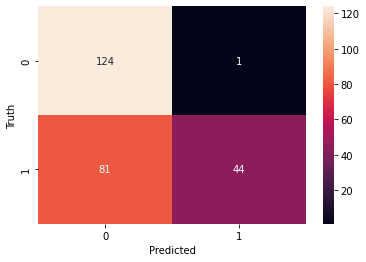

In [146]:
#Heat map
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm2, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [147]:
print(classification_report(y_test2, y_predicted2))

              precision    recall  f1-score   support

           0       0.60      0.99      0.75       125
           1       0.98      0.35      0.52       125

    accuracy                           0.67       250
   macro avg       0.79      0.67      0.63       250
weighted avg       0.79      0.67      0.63       250



# **Contextual embeddings using ALBERT-base model**

In [148]:
#We split our dataset into test and train
#We define the Albert model consisting of input, preprocessing, encoding, neural network layers and finally producing output
#These outputs are the probability values of the news text being fake or not. If these values are greater than 0.5, we assign fake label or 1 in our case. Otherwise, we provide label as 0.
#Then we fit these models in 5 epochs

In [149]:
#ALBERT preprocessor and ALBERT encoder
albert_preprocess = hub.KerasLayer("http://tfhub.dev/tensorflow/albert_en_preprocess/3")
albert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/albert_en_base/3")

In [150]:
#Splitting into test and train
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(news1['text'],news1["fake"], stratify = news1['fake'],random_state = 2)

In [151]:
#Defining the bert model consisting of input, preprocessing, encoding, neural network layers and finally producing output
# AlBert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = albert_preprocess(text_input)
outputs = albert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
almodel = tf.keras.Model(inputs=[text_input], outputs = [l])

In [152]:
almodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_6 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [153]:
#Defining metrics for model evaluation
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

almodel.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)


In [154]:
#Fitting the model
almodel.fit(X_train3, y_train3, epochs=5)

Epoch 1/5
24/24 [==============================] - 433s 17s/step - loss: 0.5408 - accuracy: 0.7373 - precision: 0.7330 - recall: 0.7467
Epoch 2/5
24/24 [==============================] - 359s 15s/step - loss: 0.3220 - accuracy: 0.9093 - precision: 0.8828 - recall: 0.9440
Epoch 3/5
24/24 [==============================] - 357s 15s/step - loss: 0.2509 - accuracy: 0.9280 - precision: 0.9105 - recall: 0.9493
Epoch 4/5
24/24 [==============================] - 363s 15s/step - loss: 0.2056 - accuracy: 0.9520 - precision: 0.9449 - recall: 0.9600
Epoch 5/5
24/24 [==============================] - 362s 15s/step - loss: 0.1753 - accuracy: 0.9587 - precision: 0.9456 - recall: 0.9733


In [155]:
almodel.evaluate(X_test3, y_test3)

8/8 [==============================] - 121s 15s/step - loss: 0.1760 - accuracy: 0.9680 - precision: 0.9835 - recall: 0.9520


[0.17596982419490814,
 0.9679999947547913,
 0.9834710955619812,
 0.9520000219345093]

In [156]:
#Making predictions
y_predicted3 = almodel.predict(X_test3)
y_predicted3 = y_predicted3.flatten()

In [157]:
#Changing probability values to 0 and 1 based on whether the value is greater than 0.5 or not
import numpy as np
y_predicted3 = np.where(y_predicted3 > 0.5, 1, 0)
y_predicted3

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1])

In [158]:
#confusion metrics
from sklearn.metrics import confusion_matrix, classification_report
cm3 = confusion_matrix(y_test3, y_predicted3)
cm3

array([[123,   2],
       [  6, 119]])

Text(33.0, 0.5, 'Truth')

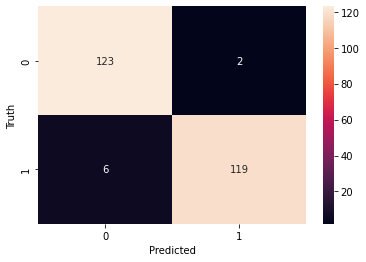

In [159]:
#Heat map
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm3, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [160]:
print(classification_report(y_test3, y_predicted3))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       125
           1       0.98      0.95      0.97       125

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



# **Result summary**

In [174]:
#Printing classification reports for classification models using following word embeddings:

In [173]:
#Word2vec
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       121
           1       0.91      0.80      0.85       129

    accuracy                           0.86       250
   macro avg       0.86      0.86      0.86       250
weighted avg       0.86      0.86      0.86       250



In [177]:
#BERT-base
print(classification_report(y_test1, y_predicted1))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       125
           1       0.87      0.83      0.85       125

    accuracy                           0.86       250
   macro avg       0.86      0.86      0.86       250
weighted avg       0.86      0.86      0.86       250



In [178]:
#BERT-large
print(classification_report(y_test2, y_predicted2))

              precision    recall  f1-score   support

           0       0.60      0.99      0.75       125
           1       0.98      0.35      0.52       125

    accuracy                           0.67       250
   macro avg       0.79      0.67      0.63       250
weighted avg       0.79      0.67      0.63       250



In [179]:
#AlBERT
print(classification_report(y_test3, y_predicted3))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       125
           1       0.98      0.95      0.97       125

    accuracy                           0.97       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.97      0.97      0.97       250



In [182]:
#We observe that classification model using word2vec embedding gives almost same results as compared to models using BERT-base embedding.
#Classification model with BERT-large embedding performs the worst giving low values for precision, recall and accuracy as compared to other cases
#Classification model with AlBERT embedding outperforms all the other models giving very high values for recall, precision and accuracy(all values closer to 0.97)
#For the task of binary text classification, we found that AlBERT model is the best as compared to BERT and word2vec.